# **Version 4**
*   Since we were not able to solve the problem
*   We trained the model again on an entirely new dataset
*   WELFake_Dataset from Kaggle






   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.3/624.3 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.1/318.1 MB 3.3 MB/s eta 0:00:00
Dataset Info:
Original dataset shape: (72134, 4)
Columns: ['Unnamed: 0', 'title', 'text', 'label']

Missing values:
Unnamed: 0      0
title         558
text           39
label           0
dtype: int64

Cleaned dataset shape: (71537, 4)
Label distribution:
label
1    36509
0    35028
Name: count, dtype: int64
Fake news (0): 35028
Real news (1): 36509

Extracting features...


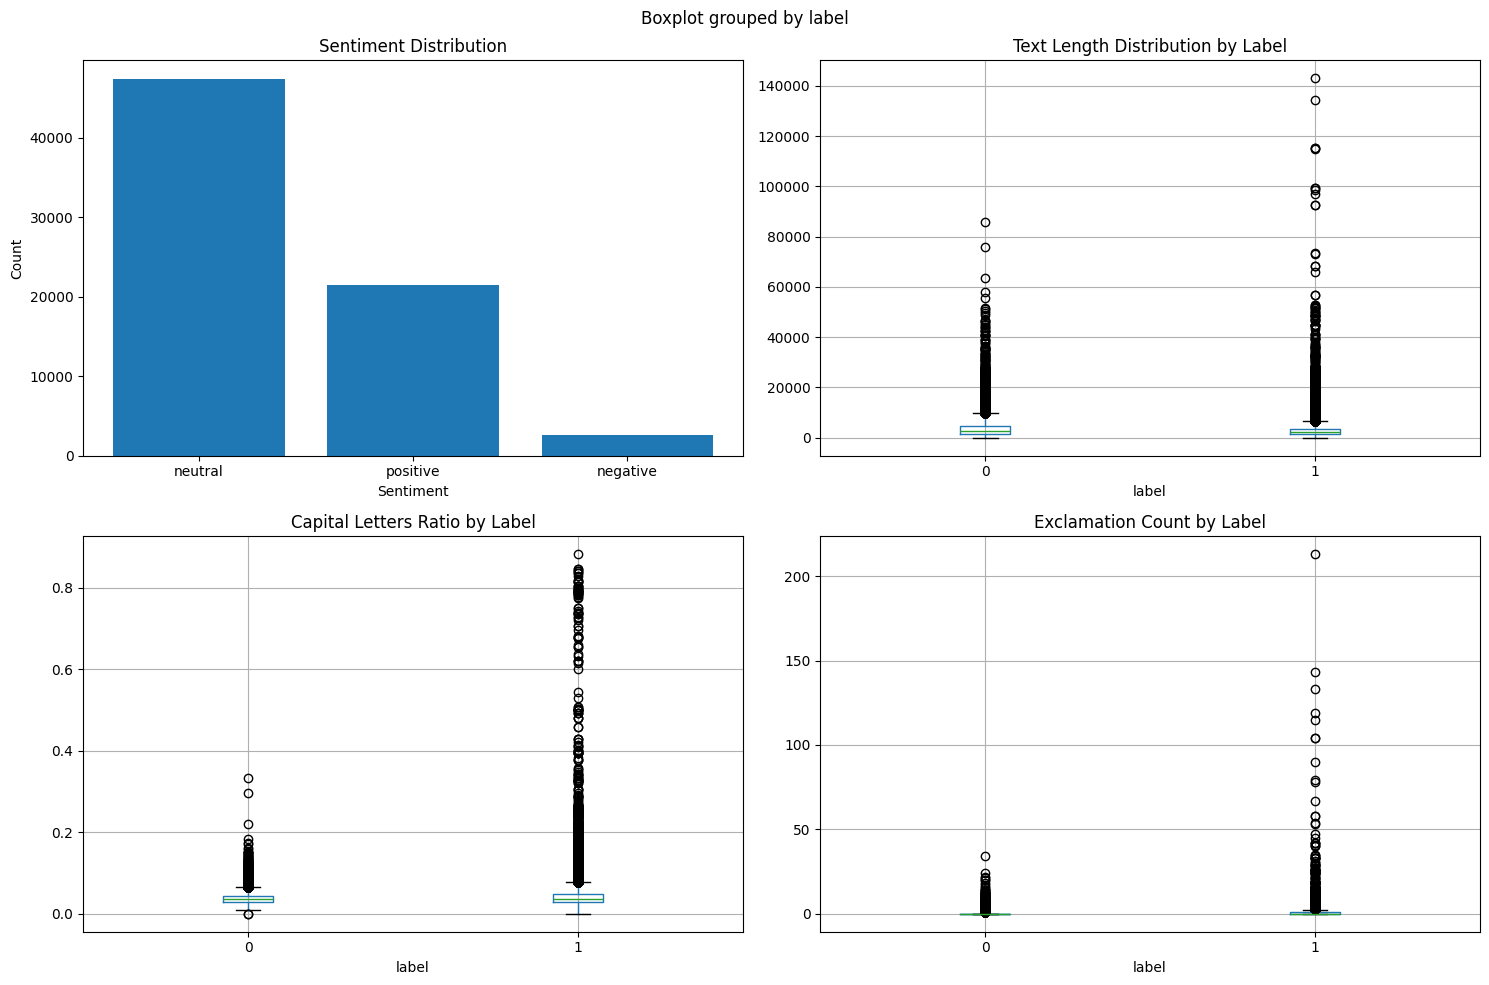


Training set size: 57229
Test set size: 14308
Combined feature matrix shape: (57229, 11018)
Training logistic...
logistic - Accuracy: 0.9579, AUC: 0.9924
Training random_forest...
random_forest - Accuracy: 0.9164, AUC: 0.9799
Training xgboost...
xgboost - Accuracy: 0.9623, AUC: 0.9948

Ensemble Model Performance:
Accuracy: 96.79%
AUC: 0.9951

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      7006
           1       0.96      0.98      0.97      7302

    accuracy                           0.97     14308
   macro avg       0.97      0.97      0.97     14308
weighted avg       0.97      0.97      0.97     14308



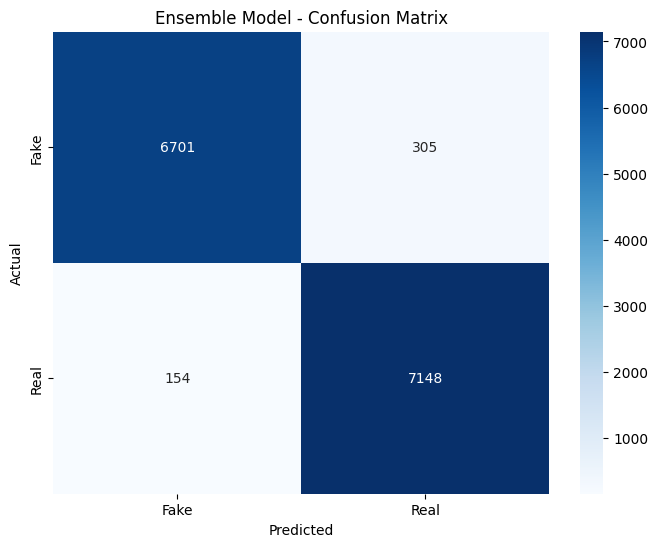

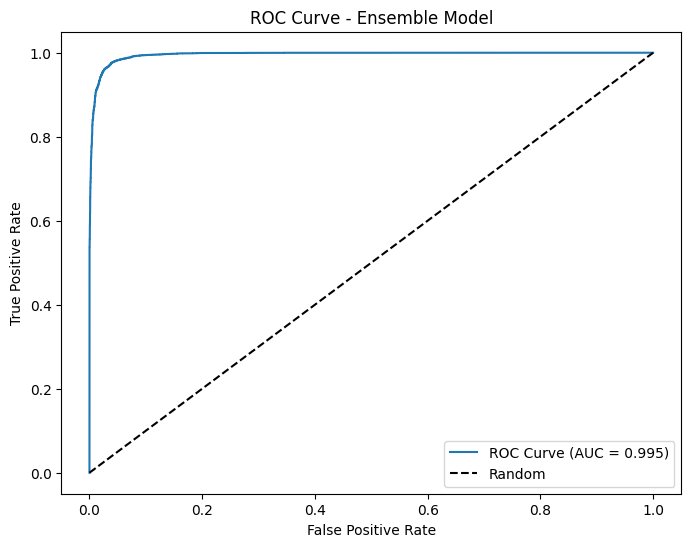


Cross-validation scores: [0.95998602 0.96479119 0.96260702 0.96365543 0.96592398]
Mean CV accuracy: 0.9634 (+/- 0.0041)

Testing with diverse examples:
Example 1: Real (Confidence: 0.908)
Text: Scientists at MIT have developed a revolutionary new battery...

Example 2: Real (Confidence: 0.949)
Text: BREAKING: SHOCKING truth about celebrities revealed! You won...

Example 3: Real (Confidence: 0.891)
Text: The Federal Reserve announced new interest rate changes foll...

Example 4: Real (Confidence: 0.966)
Text: URGENT: This miracle cure will solve all your problems insta...

Example 5: Real (Confidence: 0.927)
Text: Climate change continues to impact global weather patterns a...

Example 6: Real (Confidence: 0.959)
Text: EXPOSED: Government conspiracy revealed by anonymous insider...


ENHANCED MODEL TRAINING COMPLETED!
Final Ensemble Accuracy: 96.79%
Final Ensemble AUC: 0.9951
Cross-validation Mean: 0.9634

Files saved:
- enhanced_news_model.joblib
- enhanced_model_stats.joblib


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Files downloaded successfully!

FLASK API PREDICTION FUNCTION READY!
Use the predict_news() function in your Flask API:
result = predict_news(title, text, model_components)


In [1]:
# Step 1: Install required libraries
!pip install textblob shap joblib scikit-learn nltk wordcloud xgboost --quiet

# Step 2: Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib
from textblob import TextBlob
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import re
import nltk
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

# Download NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('vader_lexicon', quiet=True)
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Step 3: Load WELFake dataset
# WELFake dataset has columns: title, text, label
# where label: 0 = fake news, 1 = real news
df = pd.read_csv("WELFake_Dataset.csv", on_bad_lines='skip')

# Data validation and cleaning
print("Dataset Info:")
print(f"Original dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

# Check for missing values and clean
print(f"\nMissing values:")
print(df.isnull().sum())

# Remove rows with missing essential data
df = df.dropna(subset=['title', 'text', 'label'])

# Ensure label is binary (0 for fake, 1 for real)
df['label'] = df['label'].astype(int)

# Shuffle the dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"\nCleaned dataset shape: {df.shape}")
print(f"Label distribution:")
print(df['label'].value_counts())
print(f"Fake news (0): {(df['label'] == 0).sum()}")
print(f"Real news (1): {(df['label'] == 1).sum()}")

# Step 4: Enhanced Text preprocessing
def advanced_preprocess_text(text):
    """
    More balanced preprocessing that retains important information
    """
    if pd.isna(text) or not text:
        return ""

    text = str(text).lower()

    # Keep some punctuation that might be important for fake news detection
    # Remove excessive punctuation but keep structure
    text = re.sub(r'[!]{2,}', ' EXCLAMATION_MULTIPLE ', text)  # Multiple exclamations
    text = re.sub(r'[?]{2,}', ' QUESTION_MULTIPLE ', text)    # Multiple questions
    text = re.sub(r'[.]{3,}', ' DOTS_MULTIPLE ', text)       # Multiple dots

    # Handle all caps words (common in fake news)
    words = text.split()
    caps_count = sum(1 for word in words if word.isupper() and len(word) > 2)
    if caps_count > 0:
        text += f' CAPS_WORDS_{min(caps_count, 5)}'

    # Remove URLs, email addresses
    text = re.sub(r'http\S+|www\S+|https\S+', ' URL ', text)
    text = re.sub(r'\S+@\S+', ' EMAIL ', text)

    # Remove excessive whitespace and special characters
    text = re.sub(r'[^a-zA-Z\s_]', ' ', text)
    text = ' '.join(text.split())

    return text

# Step 5: Enhanced Feature Engineering
def extract_advanced_features(df):
    """Extract multiple types of features"""

    # Apply preprocessing
    df["processed_text"] = df["text"].apply(advanced_preprocess_text)
    df["processed_title"] = df["title"].apply(advanced_preprocess_text)

    # Basic length features
    df["text_length"] = df["text"].apply(len)
    df["title_length"] = df["title"].apply(len)
    df["word_count"] = df["processed_text"].apply(lambda x: len(x.split()))
    df["sentence_count"] = df["text"].apply(lambda x: len(x.split('.')))

    # Readability features
    df["avg_word_length"] = df["processed_text"].apply(
        lambda x: np.mean([len(word) for word in x.split()]) if x.split() else 0
    )
    df["avg_sentence_length"] = df["word_count"] / df["sentence_count"].replace(0, 1)

    # Punctuation features
    df["exclamation_count"] = df["text"].apply(lambda x: x.count('!'))
    df["question_count"] = df["text"].apply(lambda x: x.count('?'))
    df["caps_ratio"] = df["text"].apply(
        lambda x: sum(1 for c in x if c.isupper()) / len(x) if len(x) > 0 else 0
    )

    # URL and mention features
    df["url_count"] = df["text"].apply(lambda x: len(re.findall(r'http\S+|www\S+', x)))
    df["mention_count"] = df["text"].apply(lambda x: len(re.findall(r'@\w+', x)))

    # Enhanced sentiment analysis using both TextBlob and VADER
    analyzer = SentimentIntensityAnalyzer()

    def get_sentiment_features(text):
        # TextBlob sentiment
        blob = TextBlob(text)
        polarity = blob.sentiment.polarity
        subjectivity = blob.sentiment.subjectivity

        # VADER sentiment
        vader_scores = analyzer.polarity_scores(text)

        return {
            'polarity': polarity,
            'subjectivity': subjectivity,
            'compound': vader_scores['compound'],
            'positive': vader_scores['pos'],
            'negative': vader_scores['neg'],
            'neutral': vader_scores['neu']
        }

    sentiment_features = df["text"].apply(get_sentiment_features)
    sentiment_df = pd.DataFrame(sentiment_features.tolist())
    df = pd.concat([df, sentiment_df], axis=1)

    # Categorical sentiment
    def get_sentiment_category(polarity):
        if polarity > 0.1:
            return "positive"
        elif polarity < -0.1:
            return "negative"
        else:
            return "neutral"

    df["sentiment_category"] = df["polarity"].apply(get_sentiment_category)

    # Title-text consistency features
    df["title_text_similarity"] = df.apply(
        lambda row: len(set(row["processed_title"].split()) &
                       set(row["processed_text"].split()[:50])) /
                   max(len(set(row["processed_title"].split())), 1), axis=1
    )

    return df

# Apply feature engineering
print("\nExtracting features...")
df = extract_advanced_features(df)

# Step 6: Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Sentiment distribution
sentiment_counts = df["sentiment_category"].value_counts()
axes[0,0].bar(sentiment_counts.index, sentiment_counts.values)
axes[0,0].set_title("Sentiment Distribution")
axes[0,0].set_xlabel("Sentiment")
axes[0,0].set_ylabel("Count")

# Text length by label
df.boxplot(column='text_length', by='label', ax=axes[0,1])
axes[0,1].set_title("Text Length Distribution by Label")

# Caps ratio by label
df.boxplot(column='caps_ratio', by='label', ax=axes[1,0])
axes[1,0].set_title("Capital Letters Ratio by Label")

# Exclamation count by label
df.boxplot(column='exclamation_count', by='label', ax=axes[1,1])
axes[1,1].set_title("Exclamation Count by Label")

plt.tight_layout()
plt.show()

# Step 7: Prepare training data
# Select features for training
feature_columns = [
    'text_length', 'title_length', 'word_count', 'sentence_count',
    'avg_word_length', 'avg_sentence_length', 'exclamation_count',
    'question_count', 'caps_ratio', 'url_count', 'mention_count',
    'polarity', 'subjectivity', 'compound', 'positive', 'negative',
    'neutral', 'title_text_similarity'
]

X_numerical = df[feature_columns]
X_text = df["processed_text"]
y = df["label"]

# Train-test split
X_train_text, X_test_text, X_train_num, X_test_num, y_train, y_test = train_test_split(
    X_text, X_numerical, y, test_size=0.2, stratify=y, random_state=42
)

print(f"\nTraining set size: {len(X_train_text)}")
print(f"Test set size: {len(X_test_text)}")

# Step 8: Enhanced Vectorization with multiple approaches
# TF-IDF with more balanced parameters
tfidf = TfidfVectorizer(
    max_features=8000,  # Increased from 5000
    stop_words='english',
    ngram_range=(1, 3),  # Include trigrams
    min_df=3,           # Slightly more restrictive
    max_df=0.85,        # More restrictive to remove very common words
    sublinear_tf=True,  # Use sublinear tf scaling
    norm='l2'
)

# Count vectorizer for character n-grams (helps with stylistic analysis)
char_vectorizer = TfidfVectorizer(
    analyzer='char',
    ngram_range=(3, 5),
    max_features=3000,
    stop_words='english'
)

# Fit vectorizers
X_train_tfidf = tfidf.fit_transform(X_train_text)
X_test_tfidf = tfidf.transform(X_test_text)

X_train_char = char_vectorizer.fit_transform(X_train_text)
X_test_char = char_vectorizer.transform(X_test_text)

# Scale numerical features
scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train_num)
X_test_num_scaled = scaler.transform(X_test_num)

# Combine all features
from scipy.sparse import hstack, csr_matrix

X_train_combined = hstack([
    X_train_tfidf,
    X_train_char,
    csr_matrix(X_train_num_scaled)
])

X_test_combined = hstack([
    X_test_tfidf,
    X_test_char,
    csr_matrix(X_test_num_scaled)
])

print(f"Combined feature matrix shape: {X_train_combined.shape}")

# Step 9: Train multiple models and create ensemble
models = {
    'logistic': LogisticRegression(
        solver='liblinear',
        random_state=42,
        C=1.0,
        class_weight='balanced'  # Handle class imbalance
    ),
    'random_forest': RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        max_depth=15,
        min_samples_split=5,
        class_weight='balanced'
    ),
    'xgboost': XGBClassifier(
        random_state=42,
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        scale_pos_weight=1
    )
}

# Train individual models
trained_models = {}
model_scores = {}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_combined, y_train)
    trained_models[name] = model

    # Evaluate
    y_pred = model.predict(X_test_combined)
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, model.predict_proba(X_test_combined)[:, 1])
    model_scores[name] = {'accuracy': acc, 'auc': auc}

    print(f"{name} - Accuracy: {acc:.4f}, AUC: {auc:.4f}")

# Create ensemble model
ensemble = VotingClassifier([
    ('logistic', trained_models['logistic']),
    ('rf', trained_models['random_forest']),
    ('xgb', trained_models['xgboost'])
], voting='soft')

ensemble.fit(X_train_combined, y_train)

# Step 10: Evaluate ensemble
y_pred_ensemble = ensemble.predict(X_test_combined)
y_proba_ensemble = ensemble.predict_proba(X_test_combined)

acc_ensemble = accuracy_score(y_test, y_pred_ensemble)
auc_ensemble = roc_auc_score(y_test, y_proba_ensemble[:, 1])

print(f"\nEnsemble Model Performance:")
print(f"Accuracy: {acc_ensemble*100:.2f}%")
print(f"AUC: {auc_ensemble:.4f}")
print(f"\nClassification Report:\n{classification_report(y_test, y_pred_ensemble)}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_ensemble)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Ensemble Model - Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba_ensemble[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_ensemble:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Ensemble Model')
plt.legend()
plt.show()

# Step 11: Cross-validation
cv_scores = cross_val_score(ensemble, X_train_combined, y_train, cv=5, scoring='accuracy')
print(f"\nCross-validation scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Step 12: Test with diverse examples
test_examples = [
    "Scientists at MIT have developed a revolutionary new battery technology that could change electric vehicles forever.",
    "BREAKING: SHOCKING truth about celebrities revealed! You won't believe what happens next!!!",
    "The Federal Reserve announced new interest rate changes following economic indicators.",
    "URGENT: This miracle cure will solve all your problems instantly! Doctors hate this trick!",
    "Climate change continues to impact global weather patterns according to recent research.",
    "EXPOSED: Government conspiracy revealed by anonymous insider with shocking evidence!"
]

print("\nTesting with diverse examples:")
for i, text in enumerate(test_examples):
    # Preprocess
    processed = advanced_preprocess_text(text)

    # Extract numerical features (simplified for testing)
    text_features = [
        len(text), len(text.split()), len(text.split('!')),
        len(text.split('?')), sum(1 for c in text if c.isupper()) / len(text),
        TextBlob(text).sentiment.polarity, TextBlob(text).sentiment.subjectivity,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0  # Padding for missing features
    ]

    # Vectorize
    tfidf_vec = tfidf.transform([processed])
    char_vec = char_vectorizer.transform([processed])
    num_vec = scaler.transform([text_features])

    # Combine features
    combined_vec = hstack([tfidf_vec, char_vec, csr_matrix(num_vec)])

    # Predict
    pred = ensemble.predict(combined_vec)[0]
    proba = ensemble.predict_proba(combined_vec)[0]

    print(f"Example {i+1}: {'Real' if pred == 1 else 'Fake'} "
          f"(Confidence: {max(proba):.3f})")
    print(f"Text: {text[:60]}...")
    print()

# Step 13: Save enhanced model components
# Save all components needed for prediction
model_components = {
    'ensemble': ensemble,
    'tfidf_vectorizer': tfidf,
    'char_vectorizer': char_vectorizer,
    'scaler': scaler,
    'feature_columns': feature_columns
}

joblib.dump(model_components, "enhanced_news_model.joblib")

# Save enhanced statistics
enhanced_stats = {
    'ensemble_accuracy': float(acc_ensemble),
    'ensemble_auc': float(auc_ensemble),
    'individual_scores': model_scores,
    'cv_scores': cv_scores.tolist(),
    'confusion_matrix': cm.tolist(),
    'feature_count': X_train_combined.shape[1],
    'training_samples': len(X_train_text)
}

joblib.dump(enhanced_stats, "enhanced_model_stats.joblib")

print("\n" + "="*50)
print("ENHANCED MODEL TRAINING COMPLETED!")
print("="*50)
print(f"Final Ensemble Accuracy: {acc_ensemble*100:.2f}%")
print(f"Final Ensemble AUC: {auc_ensemble:.4f}")
print(f"Cross-validation Mean: {cv_scores.mean():.4f}")
print("\nFiles saved:")
print("- enhanced_news_model.joblib")
print("- enhanced_model_stats.joblib")

# Download files (for Colab)
try:
    from google.colab import files
    files.download("enhanced_news_model.joblib")
    files.download("enhanced_model_stats.joblib")
    print("Files downloaded successfully!")
except:
    print("Not running in Colab - files saved locally.")

# Step 14: Create prediction function for Flask API compatibility
def predict_news(title, text, model_components):
    """
    Prediction function compatible with Flask API
    Args:
        title: News title
        text: News content
        model_components: Loaded model components dictionary
    Returns:
        dict: Prediction results
    """

    # Extract components
    ensemble = model_components['ensemble']
    tfidf_vectorizer = model_components['tfidf_vectorizer']
    char_vectorizer = model_components['char_vectorizer']
    scaler = model_components['scaler']
    feature_columns = model_components['feature_columns']

    # Preprocess text
    processed_text = advanced_preprocess_text(text)
    processed_title = advanced_preprocess_text(title)

    # Extract numerical features
    text_length = len(text)
    title_length = len(title)
    word_count = len(processed_text.split())
    sentence_count = len(text.split('.'))

    avg_word_length = np.mean([len(word) for word in processed_text.split()]) if processed_text.split() else 0
    avg_sentence_length = word_count / sentence_count if sentence_count > 0 else 0

    exclamation_count = text.count('!')
    question_count = text.count('?')
    caps_ratio = sum(1 for c in text if c.isupper()) / len(text) if len(text) > 0 else 0

    url_count = len(re.findall(r'http\S+|www\S+', text))
    mention_count = len(re.findall(r'@\w+', text))

    # Sentiment analysis
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    subjectivity = blob.sentiment.subjectivity

    analyzer = SentimentIntensityAnalyzer()
    vader_scores = analyzer.polarity_scores(text)

    compound = vader_scores['compound']
    positive = vader_scores['pos']
    negative = vader_scores['neg']
    neutral = vader_scores['neu']

    # Title-text similarity
    title_text_similarity = len(set(processed_title.split()) &
                                set(processed_text.split()[:50])) / max(len(set(processed_title.split())), 1)

    # Create feature vector
    numerical_features = [
        text_length, title_length, word_count, sentence_count,
        avg_word_length, avg_sentence_length, exclamation_count,
        question_count, caps_ratio, url_count, mention_count,
        polarity, subjectivity, compound, positive, negative,
        neutral, title_text_similarity
    ]

    # Vectorize text
    tfidf_vec = tfidf_vectorizer.transform([processed_text])
    char_vec = char_vectorizer.transform([processed_text])
    num_vec = scaler.transform([numerical_features])

    # Combine features
    combined_vec = hstack([tfidf_vec, char_vec, csr_matrix(num_vec)])

    # Make prediction
    prediction = ensemble.predict(combined_vec)[0]
    probabilities = ensemble.predict_proba(combined_vec)[0]

    return {
        'prediction': int(prediction),
        'label': 'Real' if prediction == 1 else 'Fake',
        'confidence': float(max(probabilities)),
        'probabilities': {
            'fake': float(probabilities[0]),
            'real': float(probabilities[1])
        }
    }

# Example usage for Flask API
print("\n" + "="*50)
print("FLASK API PREDICTION FUNCTION READY!")
print("="*50)
print("Use the predict_news() function in your Flask API:")
print("result = predict_news(title, text, model_components)")

# **Data Set Info**

In [2]:
import pandas as pd
import numpy as np
import json
from datetime import datetime
import os

def analyze_dataset(df, dataset_name):
    """Analyze a single dataset and return comprehensive information"""

    # Basic info
    info = {
        'dataset_name': dataset_name,
        'shape': {
            'rows': int(df.shape[0]),
            'columns': int(df.shape[1])
        },
        'columns': list(df.columns),
        'data_types': {},
        'memory_usage': {},
        'missing_values': {},
        'summary_stats': {},
        'sample_data': {},
        'unique_counts': {},
        'analysis_timestamp': datetime.now().isoformat()
    }

    # Data types and memory usage
    for col in df.columns:
        info['data_types'][col] = str(df[col].dtype)
        info['memory_usage'][col] = int(df[col].memory_usage(deep=True))
        info['missing_values'][col] = int(df[col].isnull().sum())
        info['unique_counts'][col] = int(df[col].nunique())

        # Sample data (first 5 non-null values)
        sample_values = df[col].dropna().head(5).tolist()
        # Convert numpy types to Python native types for JSON serialization
        info['sample_data'][col] = [
            item.item() if hasattr(item, 'item') else str(item)
            for item in sample_values
        ]

    # Summary statistics for numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        stats = df[numeric_cols].describe()
        for col in numeric_cols:
            info['summary_stats'][col] = {
                'count': int(stats.loc['count', col]),
                'mean': float(stats.loc['mean', col]),
                'std': float(stats.loc['std', col]),
                'min': float(stats.loc['min', col]),
                '25%': float(stats.loc['25%', col]),
                '50%': float(stats.loc['50%', col]),
                '75%': float(stats.loc['75%', col]),
                'max': float(stats.loc['max', col])
            }

    # Additional insights
    info['insights'] = {
        'total_missing_values': int(df.isnull().sum().sum()),
        'missing_percentage': float((df.isnull().sum().sum() / (df.shape[0] * df.shape[1])) * 100),
        'duplicate_rows': int(df.duplicated().sum()),
        'numeric_columns': len(numeric_cols),
        'categorical_columns': len(df.select_dtypes(include=['object']).columns),
        'datetime_columns': len(df.select_dtypes(include=['datetime64']).columns)
    }

    return info

def load_and_analyze_datasets():
    """Load all datasets and analyze them"""

    datasets = ['Fake.csv', 'True.csv', 'bbc_news.csv', 'WELFake_Dataset.csv']
    all_datasets_info = {
        'analysis_summary': {
            'total_datasets': 0,
            'analysis_date': datetime.now().isoformat(),
            'datasets_analyzed': []
        },
        'datasets': {}
    }

    for dataset_file in datasets:
        try:
            print(f"Analyzing {dataset_file}...")

            # Load dataset
            df = pd.read_csv(dataset_file)

            # Analyze dataset
            dataset_info = analyze_dataset(df, dataset_file)

            # Store in main structure
            all_datasets_info['datasets'][dataset_file] = dataset_info
            all_datasets_info['analysis_summary']['datasets_analyzed'].append(dataset_file)

            print(f"✓ {dataset_file}: {df.shape[0]} rows, {df.shape[1]} columns")

        except FileNotFoundError:
            print(f"✗ {dataset_file}: File not found")
            all_datasets_info['datasets'][dataset_file] = {
                'error': 'File not found',
                'dataset_name': dataset_file
            }
        except Exception as e:
            print(f"✗ {dataset_file}: Error - {str(e)}")
            all_datasets_info['datasets'][dataset_file] = {
                'error': str(e),
                'dataset_name': dataset_file
            }

    all_datasets_info['analysis_summary']['total_datasets'] = len(all_datasets_info['analysis_summary']['datasets_analyzed'])

    return all_datasets_info

def save_analysis_results(analysis_data):
    """Save analysis results to multiple formats"""

    # Save as JSON (main format for frontend)
    with open('datasets_analysis.json', 'w', encoding='utf-8') as f:
        json.dump(analysis_data, f, indent=2, ensure_ascii=False)

    # Save as a more readable text summary
    with open('datasets_summary.txt', 'w', encoding='utf-8') as f:
        f.write("DATASET ANALYSIS SUMMARY\n")
        f.write("=" * 50 + "\n\n")

        for dataset_name, info in analysis_data['datasets'].items():
            if 'error' in info:
                f.write(f"{dataset_name}: ERROR - {info['error']}\n\n")
                continue

            f.write(f"Dataset: {dataset_name}\n")
            f.write("-" * 30 + "\n")
            f.write(f"Shape: {info['shape']['rows']} rows × {info['shape']['columns']} columns\n")
            f.write(f"Columns: {', '.join(info['columns'])}\n")
            f.write(f"Missing values: {info['insights']['total_missing_values']} ({info['insights']['missing_percentage']:.2f}%)\n")
            f.write(f"Duplicate rows: {info['insights']['duplicate_rows']}\n")
            f.write(f"Numeric columns: {info['insights']['numeric_columns']}\n")
            f.write(f"Categorical columns: {info['insights']['categorical_columns']}\n\n")

    # Create a compact summary for quick reference
    compact_summary = {
        'summary': {
            'total_datasets': analysis_data['analysis_summary']['total_datasets'],
            'analysis_date': analysis_data['analysis_summary']['analysis_date']
        },
        'datasets_overview': {}
    }

    for dataset_name, info in analysis_data['datasets'].items():
        if 'error' not in info:
            compact_summary['datasets_overview'][dataset_name] = {
                'rows': info['shape']['rows'],
                'columns': info['shape']['columns'],
                'missing_percentage': info['insights']['missing_percentage'],
                'duplicate_rows': info['insights']['duplicate_rows']
            }

    with open('datasets_compact_summary.json', 'w', encoding='utf-8') as f:
        json.dump(compact_summary, f, indent=2)

def main():
    """Main execution function"""
    print("Starting dataset analysis...")
    print("=" * 50)

    # Analyze all datasets
    analysis_results = load_and_analyze_datasets()

    print("\n" + "=" * 50)
    print("Saving analysis results...")

    # Save results
    save_analysis_results(analysis_results)

    print("✓ datasets_analysis.json - Complete analysis (for frontend)")
    print("✓ datasets_summary.txt - Human-readable summary")
    print("✓ datasets_compact_summary.json - Quick overview")

    print("\nAnalysis complete!")
    print(f"Successfully analyzed {analysis_results['analysis_summary']['total_datasets']} datasets")

if __name__ == "__main__":
    main()

Starting dataset analysis...
Analyzing Fake.csv...
✓ Fake.csv: 23481 rows, 4 columns
Analyzing True.csv...
✓ True.csv: 21417 rows, 4 columns
Analyzing bbc_news.csv...
✓ bbc_news.csv: 42115 rows, 5 columns
Analyzing WELFake_Dataset.csv...
✓ WELFake_Dataset.csv: 72134 rows, 4 columns

Saving analysis results...
✓ datasets_analysis.json - Complete analysis (for frontend)
✓ datasets_summary.txt - Human-readable summary
✓ datasets_compact_summary.json - Quick overview

Analysis complete!
Successfully analyzed 4 datasets
